# Blockwise Ensemble Methods

Dask-ML provides some [ensemble methods](https://ml.dask.org/modules/api.html#module-dask_ml.ensemble) that are tailored to `dask.array`'s and `dask.dataframe`'s blocked structure. The basic idea is to fit a copy of some sub-estimator to each block (or partition) of the dask Array or DataFrame. Becuase each block fits in memory, the sub-estimator only needs to handle in-memory data structures like a NumPy array or pandas DataFrame. It also will be relatively fast, since each block fits in memory and we won't need to move large amounts of data between workers on a cluster. We end up with an ensemble of models: one per block in the training dataset.

At prediction time, we combine the results from all the models in the ensemble. For regression problems, this means averaging the predictions from each sub-estimator. For classification problems, each sub-estimator votes and the results are combined. See https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier for details on how they can be combeind. See https://scikit-learn.org/stable/modules/ensemble.html for a general overview of why averaging ensemble methods can be useful.

It's crucially important that the distribution of values in your dataset be relatively uniform across partitions. Otherwise the parameters learned on any given partition of the data will be poor for the dataset as a whole. This will be shown in detail later.

Let's randomly generate an example dataset. In practice, you would load the data from storage. We'll create a `dask.array` with 10 blocks.

In [1]:
from distributed import Client
import dask_ml.datasets
import dask_ml.ensemble

client = Client(n_workers=4, threads_per_worker=1)

X, y = dask_ml.datasets.make_classification(n_samples=1_000_000,
                                            n_informative=10,
                                            shift=2, scale=2,
                                            chunks=100_000)
X

dask.array<normal, shape=(1000000, 20), dtype=float64, chunksize=(100000, 20), chunktype=numpy.ndarray>

## Classification

The `sub-estimator` should be an instantiated scikit-learn-API compatible estimator (anything that implements the `fit` / `predict` API, including pipelines). It only needs to handle in-memory datasets. We'll use `sklearn.linear_model.RidgeClassifier`.

To get the output shapes right, we require that you provide the `classes` for classification problems, either when creating the estimator or in `.fit` if the sub-estimator also requires the classes.

In [2]:
import sklearn.linear_model

subestimator = sklearn.linear_model.RidgeClassifier(random_state=0)
clf = dask_ml.ensemble.BlockwiseVotingClassifier(
    subestimator,
    classes=[0, 1]
)
clf

BlockwiseVotingClassifier(classes=[0, 1],
                          estimator=RidgeClassifier(random_state=0))

We can train normally. This will *independently* fit a clone of `subestimator` on each partition of `X` and `y`.

In [3]:
clf.fit(X, y)

All of the fitted estimators are available at `.estimators_`.

In [4]:
clf.estimators_

[RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0)]

These are different estimators! They've been trained on separate batches of data and have learned different parameters. We can plot the difference in the learned `coef_` of the first two models to visualize this.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

[[],
 Text(0.5, 0, 'Feature'),
 Text(0.5, 1.0, 'Difference in Learned Coefficients')]

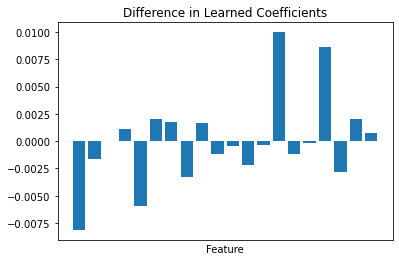

In [6]:
a = clf.estimators_[0].coef_
b = clf.estimators_[1].coef_

fig, ax = plt.subplots()
ax.bar(np.arange(a.shape[1]), (a - b).ravel())
ax.set(xticks=[], xlabel="Feature", title="Difference in Learned Coefficients");

That said, the assumption backing this entire process is that the distribution of the data is relatively uniform across partitions. The parameters learned by the each member of the ensemble should be relatively similar, and so will give relatively similar predictions when applied to the same data.

When you `predict`, the result will have the same chunking pattern as the input array you're predicting for (which need not match the partitioning of the training data).

In [7]:
preds = clf.predict(X)
preds

dask.array<_vote_block, shape=(1000000,), dtype=int64, chunksize=(100000,), chunktype=numpy.ndarray>

This generates a set of tasks that

1. Calls `subestimator.predict(chunk)` for each subestimator (10 in our case)
2. Concatenates those predictions together
3. Somehow averages the predictions to a single overall prediction

We used the default `voting="hard"` strategy, which means we just choose the class that had the higest number of votes. If the first two sub-estimators picked class `0` and the other eight picked class `1` for the first row, the final prediction for that row will be class `1`.

In [8]:
preds[:10].compute()

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0])

With `voting="soft"` we have access to `predict_proba`, as long as the subestimator has a `predict_proba` method. These subestimators should be well-calibrated for the predictions to be meaningful. See [probability calibration](https://scikit-learn.org/stable/modules/calibration.html#calibration) for more.

In [9]:
subestimator = sklearn.linear_model.LogisticRegression(random_state=0)
clf = dask_ml.ensemble.BlockwiseVotingClassifier(
    subestimator,
    classes=[0, 1],
    voting="soft"
)
clf.fit(X, y)

In [10]:
proba = clf.predict_proba(X)
proba[:5].compute()

array([[0.08181361, 0.91818639],
       [0.9604897 , 0.0395103 ],
       [0.99554763, 0.00445237],
       [0.92836372, 0.07163628],
       [0.18885517, 0.81114483]])

The stages here are similar to the `voting="hard"` case. Only now instead of taking the majority vote we average the probabilities predicted by each sub-estimator.

## Regression

Regression is quite similar. The primary difference is that there's no voting; predictions from estimators are always reduced by averaging.

In [11]:
X, y = dask_ml.datasets.make_regression(n_samples=1_000_000,
                                        chunks=100_000,
                                        n_features=20)
X

dask.array<normal, shape=(1000000, 20), dtype=float64, chunksize=(100000, 20), chunktype=numpy.ndarray>

In [12]:
subestimator = sklearn.linear_model.LinearRegression()
clf = dask_ml.ensemble.BlockwiseVotingRegressor(
    subestimator,
)
clf.fit(X, y)

In [13]:
clf.predict(X)[:5].compute()

array([  70.620474  ,  107.15992886, -198.43650675,  210.33759339,
        235.39421031])

As usual with Dask-ML, scoring is done in parallel (and distributed on a cluster if you're connected to one).

In [14]:
clf.score(X, y)

1.0

## The dangers of non-uniformly distributed data

Finally, it must be re-emphasized that your data should be uniformly distributed across partitoins prior to using these ensemble methods. If it's not, then you're better off just sampling rows from each partition and fitting a single classifer to it. By "uniform" we don't mean "from a uniform probabillity distribution". Just that there shouldn't be a clear per-partition pattern to how the data is distributed.

Let's demonstrate that with an example. We'll generate a dataset with a clear trend across partitions. This might represent some non-stationary time-series, though it can occur in other contexts as well (e.g. on data partitioned by geography, age, etc.)

In [15]:
import dask.array as da
import dask.delayed
import sklearn.datasets

In [16]:
def clone_and_shift(X, y, i):
    X = X.copy()
    X += i + np.random.random(X.shape)
    y += 25 * (i + np.random.random(y.shape))
    return X, y

In [17]:
# Make a base dataset that we'll clone and shift
X, y = sklearn.datasets.make_regression(n_features=4, bias=2, random_state=0)

# Clone and shift 10 times, gradually increasing X and y for each partition
Xs, ys = zip(*[dask.delayed(clone_and_shift, nout=2)(X, y, i) for i in range(10)])
Xs = [da.from_delayed(x, shape=X.shape, dtype=X.dtype) for x in Xs]
ys = [da.from_delayed(y_, shape=y.shape, dtype=y.dtype) for y_ in ys]
X2 = da.concatenate(Xs)
y2 = da.concatenate(ys)

Let's plot a sample of points, coloring by which partition the data came from.

[Text(0.5, 0, 'Feature 0'),
 Text(0, 0.5, 'target'),
 Text(0.5, 1.0, 'Non-stationary data (by partition)')]

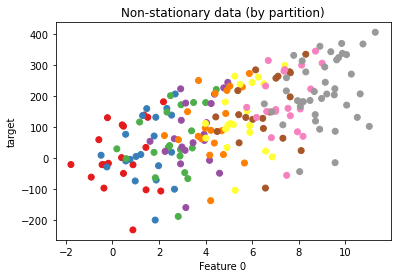

In [18]:
fig, ax = plt.subplots()
ax.scatter(X2[::5, 0], y2[::5], c=np.arange(0, len(X2), 5) // 100, cmap="Set1",
           label="Partition")
ax.set(xlabel="Feature 0", ylabel="target", title="Non-stationary data (by partition)");

Now let's fit two estimators:

1. One `BlockwiseVotingRegressor` on the entire dataset (which fits a `LinearRegression` on each partition)
2. One `LinearRegression` on a sample from the entire dataset

In [19]:
subestimator = sklearn.linear_model.LinearRegression()
clf = dask_ml.ensemble.BlockwiseVotingRegressor(
    subestimator,
)
clf.fit(X2, y2)

In [20]:
X_sampled, y_sampled = dask.compute(X2[::10], y2[::10])

subestimator.fit(X_sampled, y_sampled)

LinearRegression()

Comparing the scores, we find that the sampled dataset performs much better, despite training on less data.

In [21]:
clf.score(X2, y2)

-11.591938909817133

In [22]:
subestimator.score(X2, y2)

0.028440147891489964

This shows that ensuring your needs to be relatively uniform across partitions. Even including the standard controls to normalize whatever underlying force is generating the non-stationary data (e.g. a time trend compontent or differencing timeseries data, dummy variables for geographic regions, etc) is not sufficient when your dataset is partioned by the non-uniform variable. You would still need to either shuffle your data prior to fitting, or just sample and fit the sub-estimator on the sub-sample that fits in memory.